# 빅데이터 분석 종합 프로젝트
### 제목 : 서프라이즈를 이용한 스마트폰 추천 시스템
### 담당 교수님 : 이수안 교수님
### 학번 : 2021218034 / 학년 : 3학년
### 이름 : 서세일


# 프로젝트 소개

## 프로젝트 아이디어 및 목적
스마트폰을 구매하는데 많은 고민을 하게됩니다. 왜냐하면  성능은 거의 평준화 되었지만 그래도 차이가 있고 더 나아가 외관까지 신경쓰기 때문입니다.

스마트폰을 구매할 때 리뷰(별점)과 빈도수를 이용하여 사람들이 많이 만족하는 스마트폰을 추천하는 것을 목적으로 프로젝트를 진행하였습니다.

## 참고한 링크
이수안 컴퓨터 연구소 (SuanLab) - 추천 시스템 Recommender System https://youtu.be/6TP51jvjLsE

## 데이터 다운로드 링크
데이터셋
- Amazon Cell Phones Reviews (Kaggle)
https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews

코드 참고
- Cellphone Recommendation using Surprise
https://www.kaggle.com/code/stpeteishii/cellphone-recommendation-using-surprise


## Surprise 간단 설명
Surprise는 데이터 처리, 다양한 추천 알고리즘, 성능평가하는 도구이며 이를 활용하여 협업 필터링 기반의 추천 시스템을 구현하고 개선할 수 있다.

서프라이즈의 주요한 세가지 모듈

- Dataset 모듈

데이터를 로드, 전처리 및 변환하기 위한 모듈으로 Surprise는 다양한 형식의 데이터를 처리할 수 있습니다. CSV, TSV, pandas DataFrame 또는 직접 정의한 형식의 데이터 파일 등을 사용할 수 있다.

- 알고리즘 모듈

추천 알고리즘을 위한 모듈 Surprise는 다양한 알고리즘을 제공합니다. 예를 들어, SVD(Singular Value Decomposition), NMF(Non-Negative Matrix Factorization) 등이 있으며 각 알고리즘은 서로 다른 방식으로 추천을 수행한다. (사용자의 선호도와 항목 간의 관계를 모델링)

- Evaluation 모듈

추천 알고리즘의 성능평가 모듈 Surprise는 교차 검증(Cross-validation), 학습-테스트 분할(Train-test split), 정확도(Precision), 재현율(Recall) 등과 같은 다양한 평가 지표를 제공 이를 통해 추천 알고리즘의 성능을 비교하고 개선할 수 있다.


## 데이터 셋 직접 업로드

In [ ]:
# from google.colab import files

# myfiles = files.upload()

## scikit-surprise 설치


In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095437 sha256=168b07a1e993df905b603eb2cb9f3d3fff74a6d4c6a6a3b1d2a22ca290dd6ab9
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## 임포트 부분

In [ ]:
import os
import random
import operator
import requests
import numpy as np
import pandas as pd
from scipy import sparse
import sys
from surprise import Dataset, Reader
from surprise import KNNBasic, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분석

## 데이터셋 확인 및 결측치 확인

Number of missing values: 0


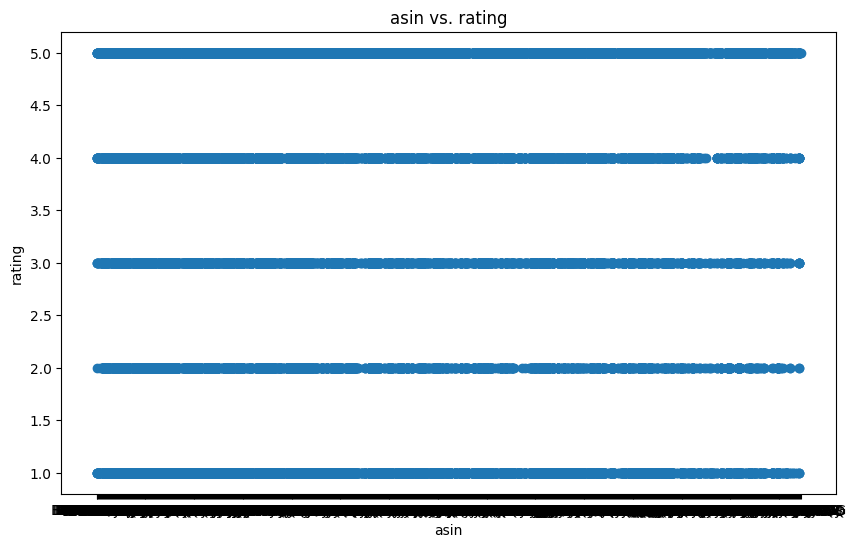

In [ ]:
df = pd.read_csv('/content/20191226-reviews.csv')
df.head()

# 결측치 확인
missing_values = df['rating'].isnull().sum()
print("Number of missing values:", missing_values)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(df['asin'], df['rating'])
plt.xlabel('asin')
plt.ylabel('rating')
plt.title('asin vs. rating')
plt.show()

## 데이터 전처리

서프라이즈를 사용하기 위해 같은 요소는 하나의 고유한 값을 가지도록 처리


혹시 모를 결측치나 오류값을 처리하기 위해 조건 지정

In [ ]:
df = pd.read_csv('/content/20191226-reviews.csv',
                          error_bad_lines=False,
                          warn_bad_lines=False,
                          skiprows=lambda i: i>0 and random.random()==1.0)
#df_playlist=df_playlist.drop('timestamp',axis=1)
print(len(df))
#df=df[0:10000]
print(df['rating'].unique().tolist())
print(len(df['name'].unique().tolist()))
print(len(df['asin'].unique().tolist()))

<ipython-input-4-2911fe8fd6e4>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/20191226-reviews.csv',
<ipython-input-4-2911fe8fd6e4>:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/20191226-reviews.csv',


67986
[3, 1, 5, 4, 2]
47324
720


## Reader 객체 생성 (데이터 셋 평점 척도 지정)

In [ ]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(df[['name', 'asin', 'rating']], reader)
print(type(data))

<class 'surprise.dataset.DatasetAutoFolds'>


#모델

## 훈련/테스트 세트의 분할 및 평가

In [ ]:
trainset, testset = train_test_split(data, test_size=0.25)
print(type(trainset))

<class 'surprise.trainset.Trainset'>


In [ ]:
import itertools

for uid, iid, rating in itertools.islice(trainset.all_ratings(), 5):
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

print()
print(trainset.n_ratings,len(testset))

User 0 rated item 0 with a rating of 5.0
User 1 rated item 1 with a rating of 1.0
User 2 rated item 2 with a rating of 5.0
User 2 rated item 196 with a rating of 5.0
User 3 rated item 3 with a rating of 4.0

User Yasser Elrafie rated item B0775451TT with a rating of 3.0
User Jhoanna rated item B019S654DO with a rating of 1.0
User Comments rated item B00WHE2WCG with a rating of 2.0
User Amazon Customer rated item B00CEKXJ3Y with a rating of 2.0
User Paul Sylvain rated item B00N532DU4 with a rating of 5.0

50989 16997


##SVD(단일 값 분해) /  KNNBasic (k-Nearest Neighbors)

SVD(단일 값 분해)
* 데이터 세트를 저차원 공간으로 분해하여 사용자와 항목 사이의 잠재적 특징을 추출
* 메모리 기반 협업 필터링 알고리듬에 비해 계산 효율이 높아 대규모 데이터 세트에도 적합
* 추천할 항목 수 및 항목 유사성 계산 방법과 같은 많은 매개 변수를 조정 필요

KNNBasic (k-Nearest Neighbors)
* 사용자 및 항목의 유사성을 바탕으로 가장 유사한 사용자 및 아이템을 찾고 있는 항목 탐색
* 계산 효율성은 상대적으로 높은 데이터 세트에 적합
* 매개 변수 수가 상대적으로 작기 때문에 튜닝하기가 쉽지 않음

In [ ]:
# algo라는 변수에 SVD 알고리즘 객체를 생성, 훈련 세트(trainset)에 모델을 피팅
algo = SVD()
algo.fit(trainset)

In [ ]:
# 훈련된 모델을 테스트 세트(testset)에 적용하여 예측을 수행
predictions = algo.test(testset)

In [ ]:
# testset은 서프라이즈에 있는 데이터 구조로, 사용자 id, 아이템 id, 평점 의 정보를 저장할 수 있다.
for uid, iid, rating in testset[:5]:
    print(f"User {uid} rated item {iid} with a rating of {rating}")

User Yasser Elrafie rated item B0775451TT with a rating of 3.0
User Jhoanna rated item B019S654DO with a rating of 1.0
User Comments rated item B00WHE2WCG with a rating of 2.0
User Amazon Customer rated item B00CEKXJ3Y with a rating of 2.0
User Paul Sylvain rated item B00N532DU4 with a rating of 5.0


In [ ]:
# 루프를 사용하여 각 예측 결과마다 예측 정보를 출력
# 예측 평점, 실제 평점, 사용자 ID, 아이템 ID 등의 정보를 확인하여 모델의 예측 성능이나 예측 결과의 일치도를 평가할 수 있ㅇ므
for prediction in predictions[0:5]:
    print(prediction)

user: Yasser Elrafie item: B0775451TT r_ui = 3.00   est = 3.55   {'was_impossible': False}
user: Jhoanna    item: B019S654DO r_ui = 1.00   est = 3.88   {'was_impossible': False}
user: Comments   item: B00WHE2WCG r_ui = 2.00   est = 3.14   {'was_impossible': False}
user: Amazon Customer item: B00CEKXJ3Y r_ui = 2.00   est = 3.26   {'was_impossible': False}
user: Paul Sylvain item: B00N532DU4 r_ui = 5.00   est = 3.64   {'was_impossible': False}


In [ ]:
# 예측 결과인 predictions를 입력으로 받아 RMSE를 계산하고 출력
# RMSE는 예측된 평점과 실제 평점 간의 차이를 측정하는 평가 지표 중 하나이다.
# 낮은 RMSE 값은 예측 모델의 성능이 더 우수함을 나타냄
accuracy.rmse(predictions)
# 1보다 크므로 성능이 우수하다고 할 수 없음

RMSE: 1.5261


1.5260630789595033

In [ ]:
# 실제 평점(r_ui), 예측 평점(est), 사용자 ID(uid)를 추출하여 각각의 정보를 리스트에 저장
true_ratings = [pred.r_ui for pred in predictions]
est_ratings = [pred.est for pred in predictions]
uids = [pred.uid for pred in predictions]

## 결과 출력

In [ ]:
# 예측 결과에서 사용자 ID 값들을 담은 리스트를 생성.
users = list(set(uids))
# 리스트의 처음 5개 값을 가져와서 출력
print(users[0:5])

['agustin', 'Robert F Ortega', 'Double H', 'Neil Smith', 'Keaton B.']


In [ ]:
# 아이템 이름을 가지고 있는 csv 파일 호출
anime = pd.read_csv('/content/20191226-items.csv')
# 'asin' 칼럼의 유일한 값들의 개수를 출력
print(len(df['asin'].unique().tolist()))
# 'asin'을 키로, 'title'을 값으로 하는 딕셔너리인 'mapping'을 생성
mapping = dict(zip(anime['asin'], anime['title']))

720


In [ ]:
# 추천 시스템에서 평가되지 않은 아이템들을 대상으로 추천을 수행
items = trainset.build_anti_testset()

# 각 사용자에 대해서 추천 아이템을 생성하고 출력합니다.
for user in users[0:5]:
    # 해당 사용자가 아직 평가하지 않은 아이템들을 필터링합니다.
    user_items = list(filter(lambda x: x[0] == user, items))

    print()
    print(user, len(user_items))

    # 추천 생성
    recommendations = algo.test(user_items)

    # 추천 결과를 예상 평점 기준으로 내림차순으로 정렬합니다.
    recommendations.sort(key=operator.itemgetter(3), reverse=True)

    print(f"User {user} recommendations:")

    # 상위 5개의 추천 결과를 출력합니다.
    for r in recommendations[0:5]:
        print(f" [Title] {mapping[r[1]]}, [Estimated Rating] {round(r[3], 3)}")


agustin 0
User agustin recommendations:

Robert F Ortega 0
User Robert F Ortega recommendations:

Double H 0
User Double H recommendations:

Neil Smith 709
User Neil Smith recommendations:
 [Title] Huawei Mate 10 Pro Unlocked Phone, 6" 6GB/128GB, AI Processor, Dual Leica Camera, Water Resistant IP67, GSM Only - Mocha Brown (US Warranty), [Estimated Rating] 5
 [Title] Samsung Galaxy Note 9 SM-N960F/DS 512GB/8GB (Metallic Copper) 6.4" QHD+ sAMOLED Factory Unlocked GSM (No CDMA) - International Version (No Warranty in The USA), [Estimated Rating] 4.904
 [Title] Xiaomi Redmi Note 8 64GB + 4GB RAM, 6.3" LTE 48MP Factory Unlocked GSM Smartphone - International Version (Space Black), [Estimated Rating] 4.828
 [Title] Xiaomi Redmi Note 7, 64GB/4GB RAM, 6.30'' FHD+, Snapdragon 660, Blue - Unlocked Global Version, No Warranty, [Estimated Rating] 4.81
 [Title] Xiaomi Redmi Note 7 (64GB, 4GB) 6.3" Display, 48MP + 5MP AI Dual Rear Camera, Global 4G LTE Dual SIM GSM Factory Unlocked (International 

# 시각화

## 데이터셋 시각화

In [ ]:
import matplotlib.pyplot as plt

### 평점 시각화 (히스토그램)

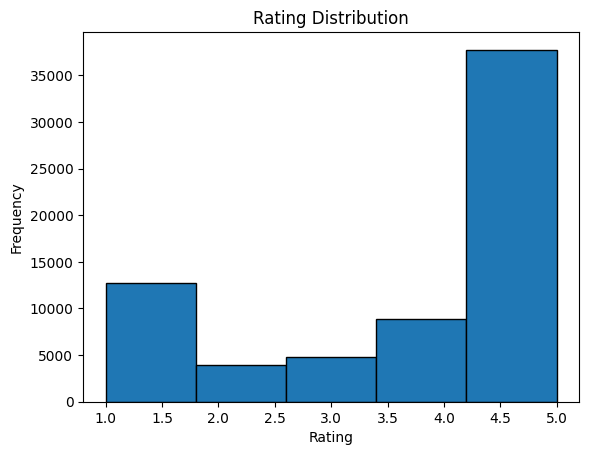

In [ ]:
plt.hist(df['rating'], bins=5, range=(1, 5), edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution')
plt.show()

### 검증 리뷰 시각화 (막대그래프)

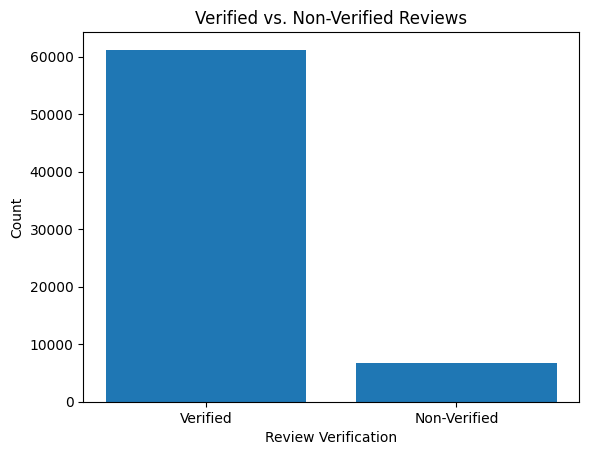

In [ ]:
verified_reviews = df[df['verified'] == True]
non_verified_reviews = df[df['verified'] == False]
verified_count = len(verified_reviews)
non_verified_count = len(non_verified_reviews)

plt.bar(['Verified', 'Non-Verified'], [verified_count, non_verified_count])
plt.xlabel('Review Verification')
plt.ylabel('Count')
plt.title('Verified vs. Non-Verified Reviews')
plt.show()

### 실제 평점과 예측평점 사이의 관계 시각화 (커널 밀도 그래프)

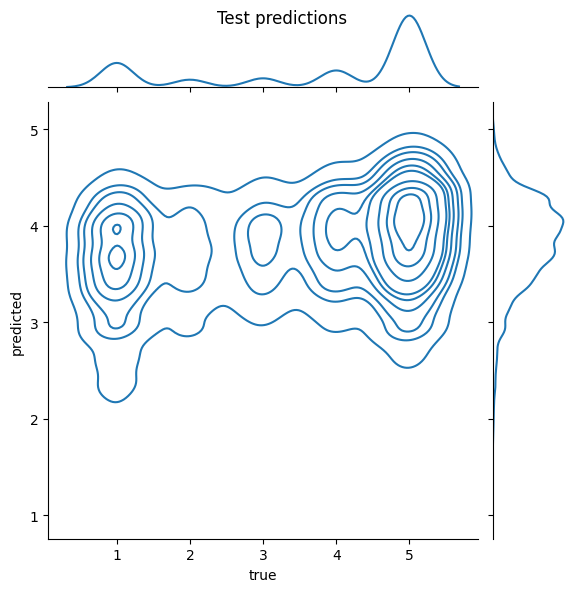

In [ ]:
data=pd.DataFrame(columns=["true","predicted"])
data["true"]=true_ratings
data["predicted"]=est_ratings
g = sns.jointplot(data=data,x="true", y="predicted", kind="kde",)
g.fig.suptitle('Test predictions',fontsize=12)
plt.show()